In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Load the combined dataset
combined_df = pd.read_csv("data/combined.csv")

# Step 2: Prepare the Data
# Assume first column is wavelength, others are sample types (flour, corn starch, etc.)
wavelengths = combined_df.iloc[:, 0]
sample_data = combined_df.iloc[:, 1:]
sample_labels = sample_data.columns

In [4]:
# Transpose so each row is one sample, and columns are wavelengths
X = sample_data.T
X.columns = wavelengths
X.index.name = 'Sample'

# Create label vector from index
labels = X.index
X = X.reset_index(drop=True)

# Step 3: Normalize the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

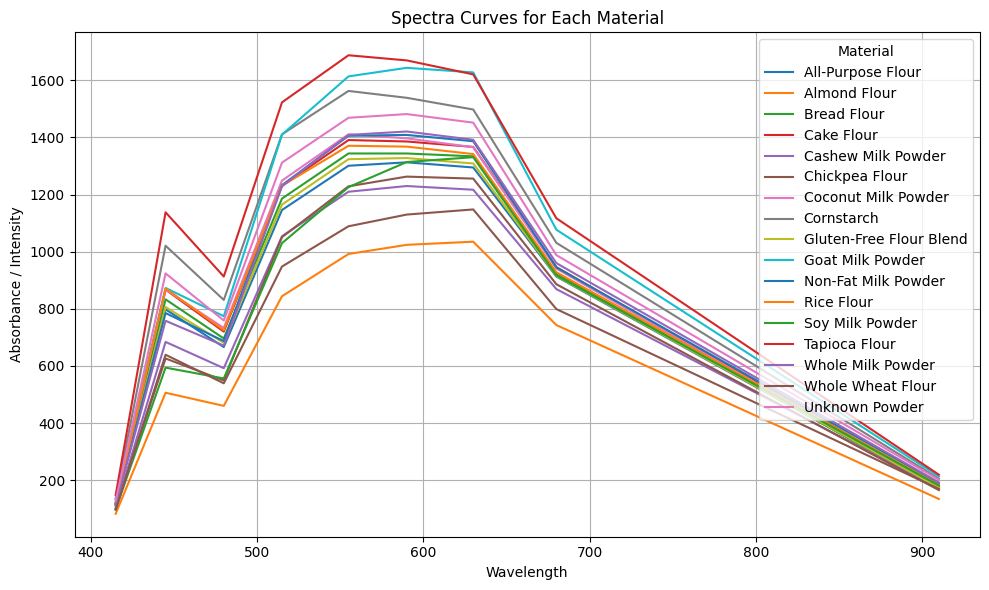

In [ ]:
# 📊 Bonus: Show Spectra Curves for Each Material to get a better sense of which are similar
plt.figure(figsize=(10, 6))
for label in sample_labels:
    plt.plot(wavelengths, combined_df[label], label=label)

plt.title("Spectra Curves for Each Material")
plt.xlabel("Wavelength")
plt.ylabel("Absorbance / Intensity")
plt.legend(title="Material")
plt.grid(True)
plt.tight_layout()
plt.show()

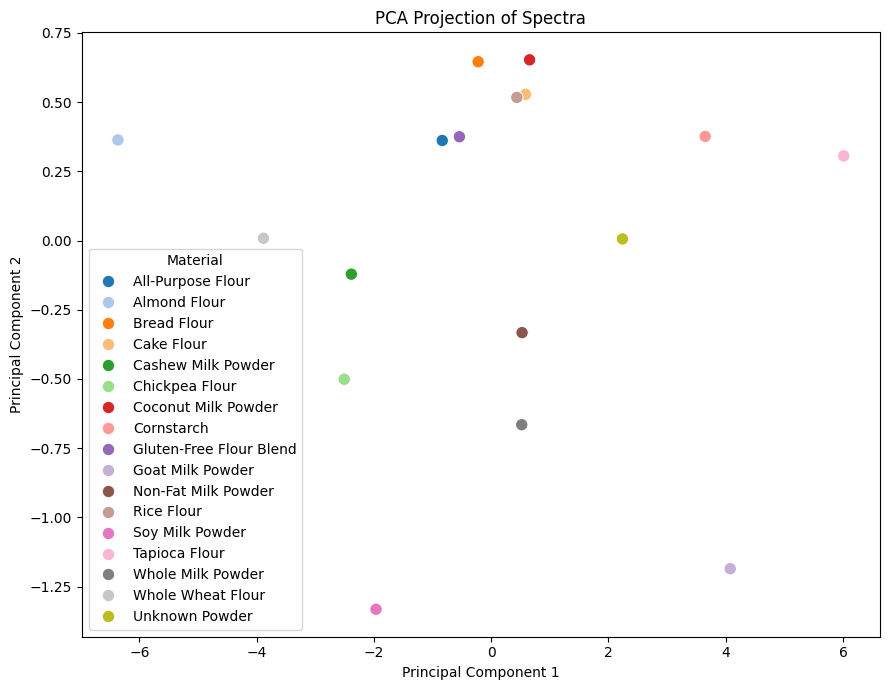

In [ ]:
# Step 4: Reduce Dimensions for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a PCA projection which can show us a basic clustering of similar materials by spectra
plt.figure(figsize=(9, 7))
palette = sns.color_palette("tab20", n_colors=17)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette=palette, s=80)
plt.title("PCA Projection of Spectra")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Material")
plt.tight_layout()
plt.show()


In [ ]:
# Step 5: Fit a Logistic Regression Model (linear classifier) which we can use to make predictions
model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, labels)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Training Accuracy: 0.82


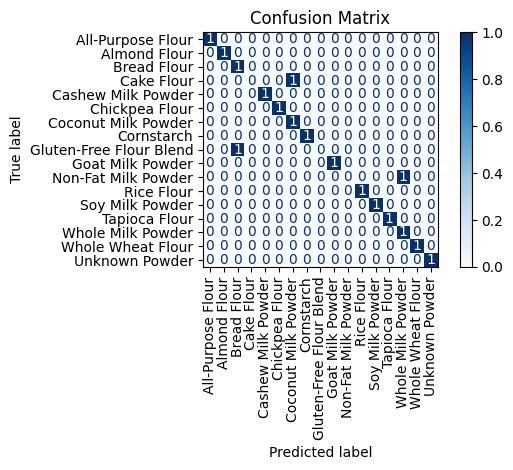

In [8]:
# Evaluate on same data (for demo purposes)
pred_labels = model.predict(X_scaled)
accuracy = accuracy_score(labels, pred_labels)
print(f"Training Accuracy: {accuracy:.2f}")

cm = confusion_matrix(labels, pred_labels, labels=labels.unique())
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels.unique()).plot(cmap="Blues", xticks_rotation=90)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# Step 6: Load Mystery Sample and Predict
mystery_df = pd.read_csv("data/MysteryPowder.csv")

# Make sure the sample is in the same format (just the intensity values)
mystery_sample = mystery_df.iloc[:, 1].values.reshape(1, -1)  # skip the wavelength column
mystery_scaled = scaler.transform(mystery_sample)


[[ 182 1348 1141 1874 2121 2121 2021 1385  334]]


In [16]:
mystery_pred = model.predict(mystery_scaled)

print(f"\n🔍 The mystery sample is predicted to be: {mystery_pred[0]}")


🔍 The mystery sample is predicted to be: Tapioca Flour
